One of the most commonly used terms in financial market data analysis is "regime". A regime refers to a market environment. In general, the market environment is known to vary depending on the time of year, and can be divided into markets with a continuing uptrend, markets with little fluctuation, and so on. When this regime is known, it is useful for forecasting, as it allows us to infer that a bull market is more likely to rise than the usual market environment.


There are various ways to estimate the market regime, but in this code, I will introduce the idea of using the number of investment_ids for each time_id.


This is a graph of the sum of investment_id by time_id, in chronological order.

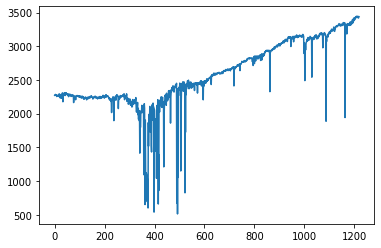

I can only speculate, but I think that the 'investment_id' are determined based on certain rules that are designed for actual operation. (In other words, the host does not intentionally limit or increase the number of stocks given.)

There are many possible reasons why the number of 'investment_id' varies.Because of trading halts and reunions, because of IPOs, because of increased liquidity and additions to the investment universe, etc.


If this supposition is correct, then the number of stocks offered reflects changes in the market environment.
Based on the above hypothesis, the idea was to add the number of 'investment_id' as a feature.



In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgbm
from lightgbm import *

First, we load the data and make it into a DataFrame.
The 'num_investment.parquet' is the given train data plus the number of 'investment_id' for each 'time_id' as a feature. (The column name is 'num_investment'.)

In [ ]:
df = pd.read_parquet('../input/num-investment/num_investment.parquet')

Split the DataFrame into train data and val data.

In [ ]:
from sklearn.model_selection import KFold, train_test_split


features = [f'f_{i}' for i in range(300)] + ['num_investment']
target = 'target'
 

df_features = df[features]


X_train, X_val, Y_train, Y_val = train_test_split(df_features, df[target], train_size=0.95, shuffle=False)

df = [[]]
df_features = [[]]

Train LightGBM.

In [ ]:
import warnings
import numpy as np
import lightgbm as lgb
from scipy.stats import pearsonr

warnings.simplefilter('ignore')

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)

params = {'seed': 1,
          'verbose' : -1,
           'objective': "regression",
           'learning_rate': 0.02,
           'bagging_fraction': 0.1,
           'bagging_freq': 1,
           'feature_fraction': 0.1,
           'max_depth': 6,
           'min_child_samples': 50,
           'num_leaves': 64}
        
        
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=3000,
                valid_sets=lgb_eval,
                verbose_eval=False,
                early_stopping_rounds=3,
                )

Displays the feature importance of LightGBM.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


feature = gbm.feature_importance(importance_type='gain')


f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)

#features' name
label = X_train.columns[0:]

#feature rank
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

As you can see from the feature importance, 'num_investment' is working as a feature.

In [ ]:
X_train = [[]]

The next step is to submit a forecast using this trained model.

In [ ]:
import ubiquant
env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    
    
    
    test_df.drop(['row_id'], axis=1, inplace=True)
    test_df.drop(['investment_id'], axis=1, inplace=True)
    test_df['num_investment'] = len(test_df)
    pred = gbm.predict(test_df)
    sample_prediction_df['target'] = pred
    env.predict(sample_prediction_df)   # register predictions
    

I submitted the file without changing anything except adding 'num_investment', and the LB improved from 0.12 → 0.124.